# 先import 所需資料

In [1]:
from datetime import datetime
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import pytz

# 連接到MT5終端


In [2]:
# establish connection to MetaTrader 5 terminal
if not mt5.initialize("C:\\Program Files\\MetaTrader 5\\terminal64.exe"):
    print("initialize() failed, error code =",mt5.last_error())
    quit()

# display data on MetaTrader 5 version
print(mt5.version())

# display info on the terminal settings and status
terminal_info=mt5.terminal_info()
if terminal_info!=None:
    # display the terminal data 'as is'
    print(terminal_info)
    # display data in the form of a list
    print("Show terminal_info()._asdict():")
    terminal_info_dict = mt5.terminal_info()._asdict()
    for prop in terminal_info_dict:
        print("  {}={}".format(prop, terminal_info_dict[prop]))
    print()
    # convert the dictionary into DataFrame and print
    df=pd.DataFrame(list(terminal_info_dict.items()),columns=['property','value'])
    print("terminal_info() as dataframe:")
    print(df)

(500, 3116, '26 Nov 2021')
TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=3116, maxbars=100000, codepage=950, ping_last=212375, community_balance=0.0, retransmission=0.0, company='MetaQuotes Software Corp.', name='MetaTrader 5', language='Chinese (Traditional)', path='C:\\Program Files\\MetaTrader 5', ...)
Show terminal_info()._asdict():
  community_account=False
  community_connection=False
  connected=True
  dlls_allowed=False
  trade_allowed=False
  tradeapi_disabled=False
  email_enabled=False
  ftp_enabled=False
  notifications_enabled=False
  mqid=False
  build=3116
  maxbars=100000
  codepage=950
  ping_last=212375
  community_balance=0.0
  retransmission=0.0
  company=MetaQuotes Software Corp.
  name=MetaTrader 5
  language=Chinese (Traditional)
  path=C:\Program Files\MetaTrader 5
  data_path

＃　取資料

In [3]:
# set time zone to TW
tw = pytz.timezone('Asia/Taipei')
# create 'datetime' objects in UTC time zone to avoid the implementation of a local time zone offset
tw_from = datetime(2010, 1, 1, tzinfo=tw)
tw_to = datetime(2015, 1, 1, tzinfo=tw)
# get bars from EURUSD H1 within the interval and convert to Dataframe
rates = pd.DataFrame(mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_H1, tw_from, tw_to))
# shut down connection to the MetaTrader 5 terminal

＃ 轉化資料格式

In [4]:
# convert .time to datetime
rates.time = pd.to_datetime(rates.time, unit='s')
# get percent change (price returns)
returns = pd.DataFrame(rates['close'].pct_change(1))
returns = returns.set_index(rates['time'])
returns = returns[1:]
returns.head(5)

,close
time,
2009-12-31 17:00:00,-0.001080
2009-12-31 18:00:00,-0.000021
2010-01-04 00:00:00,-0.001068
2010-01-04 01:00:00,-0.001865
2010-01-04 02:00:00,-0.001267


# 觀察日內小時的percent變化
(因為離群值較多所以取median)

<AxesSubplot:title={'center':'close'}, xlabel='hour'>

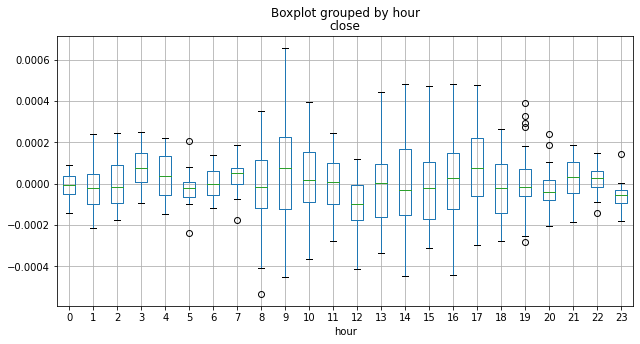

In [19]:
Hourly_Returns = returns.groupby([returns.index.day.rename('day'), returns.index.hour.rename('hour')]).median()
Hourly_Returns.boxplot(column='close', by='hour', figsize=(10, 5))

# 觀察日內小時隨均線的變化
均線天數要合理設，否則時間序列可能會太平滑。 在這種情況下，交易信號極少。 如果縮短平滑周期，那麽高頻成交可能無法負擔點差和傭金(過度交易)

In [9]:
# get percent change (price returns)
MA_rates = pd.DataFrame(rates['close'])
MA_rates = MA_rates.set_index(rates['time'])
MA_rates = MA_rates[1:]
MA_rates.head(5)

,close
time,
2009-12-31 17:00:00,1.43309
2009-12-31 18:00:00,1.43306
2010-01-04 00:00:00,1.43153
2010-01-04 01:00:00,1.42886
2010-01-04 02:00:00,1.42705


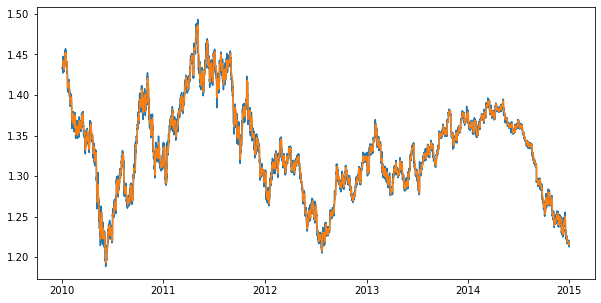

In [14]:
# set the moving average period
window = 25
# detrend tome series by MA
MA_ratesM = MA_rates.rolling(window).mean()
MA_ratesD = MA_rates[window:] - MA_ratesM[window:]

plt.figure(figsize=(10, 5))
plt.plot(MA_rates)
plt.plot(MA_ratesM)


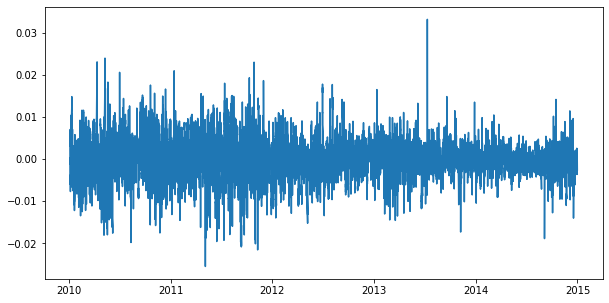

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(MA_ratesD)

## 四分位的變化
可以觀察到12 ~ 17的時候，容易有下殺到均線以下。
## 標準差
除了觀察四分位的變化，更嚴謹的做法還要檢查標準差，並且觀察到在哪幾個"時"間具有最穩定的價格行為，可以進行均值回歸策略。其他時間可能會有異常值
## 偏度
偏度系數的絕對值越大，表示觀測到的值在正向或負向的偏離度越大（此時中位數和平均值出現顯著偏離，然後較高的標準差，並不意味著有較大的偏度，在某些時間，雖然波動較大，然而分布偏度較小，意味著資料分布更穩定、對稱
## 峰度
峰度很大，意味著觀察值集中，尾部偏短偏薄，這時候還要結合著尾部的穩定系數來看。當尾部薄而短的時候，在兩端股票的分數波動比較大（不穩定）

<AxesSubplot:title={'center':'close'}, xlabel='hour'>

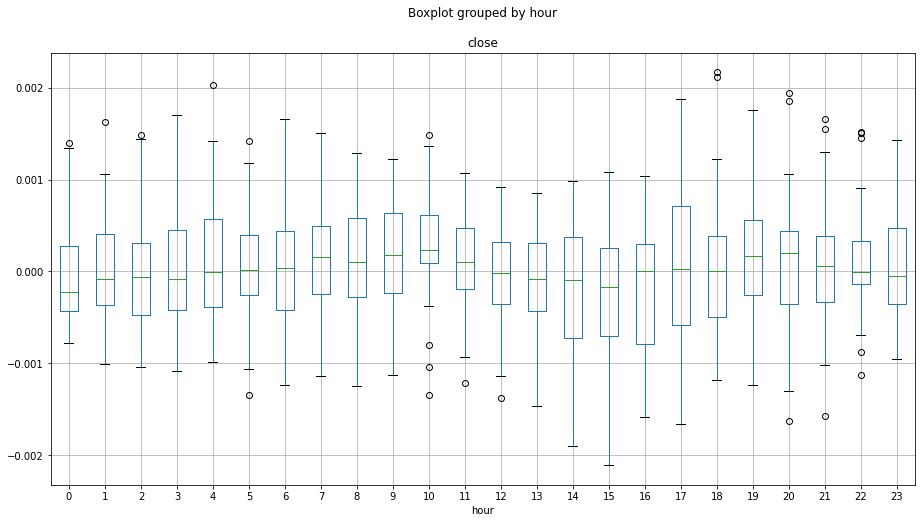

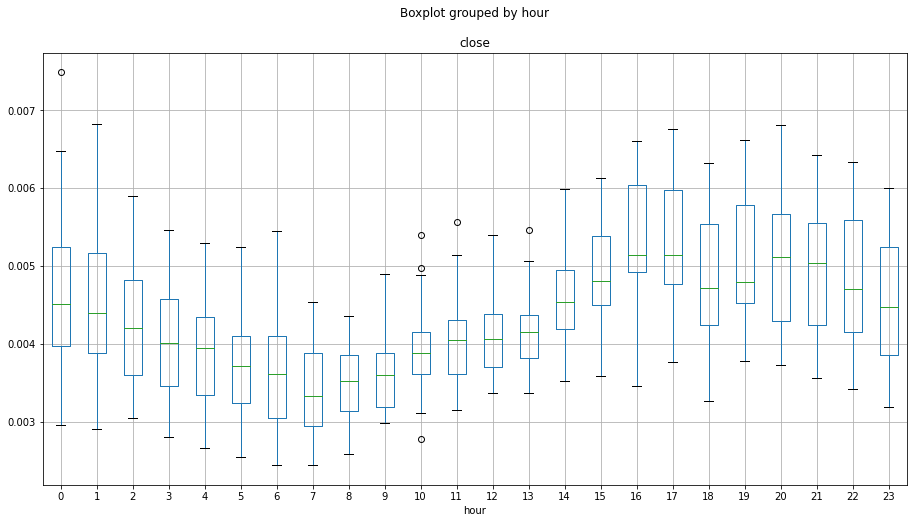

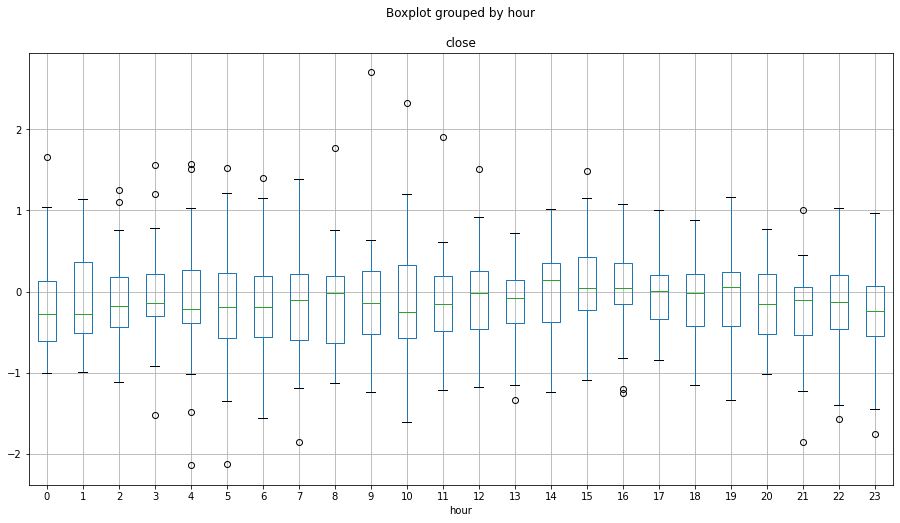

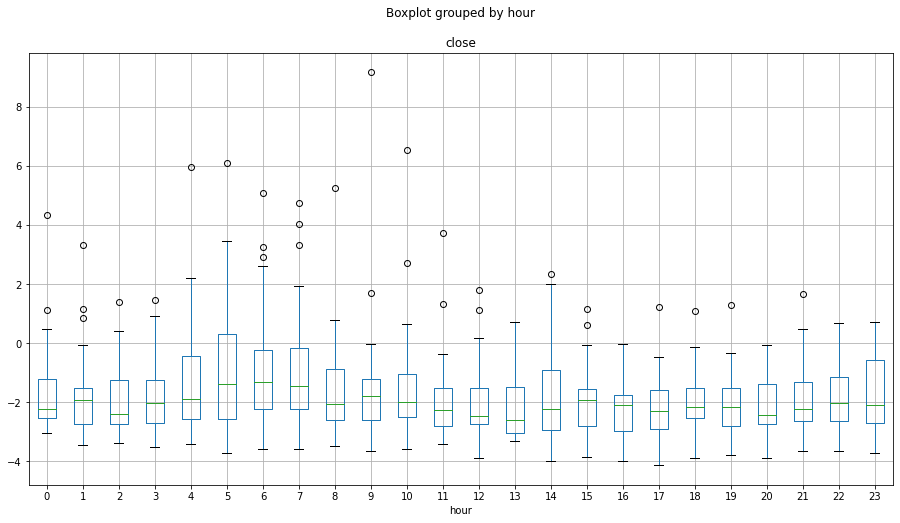

In [23]:
Hourly_MA_Returns = MA_ratesD.groupby([MA_ratesD.index.day.rename('day'), MA_ratesD.index.hour.rename('hour')]).median()
Hourly_MA_Returns.boxplot(column='close', by='hour', figsize=(15, 8))

Hourly_MA_std = MA_ratesD.groupby([MA_ratesD.index.day.rename('day'), MA_ratesD.index.hour.rename('hour')]).std()
Hourly_MA_std.boxplot(column='close', by='hour', figsize=(15, 8))

Hourly_MA_skew = MA_ratesD.groupby([MA_ratesD.index.day.rename('day'), MA_ratesD.index.hour.rename('hour')]).skew()
Hourly_MA_skew.boxplot(column='close', by='hour', figsize=(15, 8))

Hourly_MA_kurt = MA_ratesD.groupby([MA_ratesD.index.day.rename('day'), MA_ratesD.index.hour.rename('hour')]).apply(pd.DataFrame.kurt) - 3
Hourly_MA_kurt.boxplot(column='close', by='hour', figsize=(15, 8))